In [ ]:
# default_exp models

In [ ]:
#all_slow

# Models
> Classes and helper functions for all Deep Learning models used in this library.

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [ ]:
# export
from lemonpie.basics import *
from lemonpie.preprocessing.vocab import *  # for loading vocabs
from lemonpie.preprocessing.transform import *  # for loading ptlist thru EHRData
from lemonpie.data import *  # for EHRData

# from lemonpie.learn import * #for fit/predict stuff
# from lemonpie.metrics import * #for auroc_score
from fastai.imports import *


In [ ]:
# export
import pytorch_lightning as pl
from torchmetrics import MetricCollection, AUROC, Accuracy


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
DEVICE

device(type='cuda')

## `get_loss_fns()`

In [ ]:
# export
def get_loss_fns(train_pos_wts, valid_pos_wts):
    """Return `nn.BCEWithLogitsLoss` with the given positive weights."""
    loss_fns = {}
    loss_fns["train"] = nn.BCEWithLogitsLoss(pos_weight=train_pos_wts)
    loss_fns["valid"] = nn.BCEWithLogitsLoss(pos_weight=valid_pos_wts)
    return loss_fns


## Dropouts 

This is the `RNNDropout` from fast.ai renamed as `InputDropout`
- [docs](https://docs.fast.ai/text.models.awdlstm.html) 
- [source](https://github.com/fastai/fastai/blob/master/fastai/text/models/awdlstm.py)

In [ ]:
# export
def dropout_mask(x, sz, p):
    """Dropout mask as described in fast.ai"""
    return x.new(*sz).bernoulli_(1 - p).div_(1 - p)


class InputDropout(nn.Module):
    """InputDropout - same as RNNDropout described in fast.ai"""

    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training or self.p == 0.0:
            return x
        m = dropout_mask(x.data, (x.size(0), 1, x.size(2)), self.p)
        return x * m


In [ ]:
x = torch.randn(2,3,5) #bs=2, seq_len(bptt)=3, x(emb width)=5
mask = dropout_mask(x, (2,1,5), 0.75)
x, mask, x*mask

(tensor([[[-1.4690,  0.0277, -0.1331,  0.1740,  0.8191],
          [-0.8025,  0.7301, -0.6208,  1.7687,  1.3979],
          [ 0.9498,  0.8998, -0.3470, -0.0348, -0.8113]],
 
         [[-0.0507, -0.0030, -0.0360,  2.3302, -0.7169],
          [-0.1136,  0.5861,  0.0504,  0.2619,  0.5032],
          [-0.9581,  0.8355,  1.3347, -0.0052,  0.7808]]]),
 tensor([[[4., 0., 0., 4., 0.]],
 
         [[0., 4., 0., 0., 4.]]]),
 tensor([[[-5.8762,  0.0000, -0.0000,  0.6961,  0.0000],
          [-3.2101,  0.0000, -0.0000,  7.0748,  0.0000],
          [ 3.7994,  0.0000, -0.0000, -0.1394, -0.0000]],
 
         [[-0.0000, -0.0118, -0.0000,  0.0000, -2.8677],
          [-0.0000,  2.3444,  0.0000,  0.0000,  2.0126],
          [-0.0000,  3.3420,  0.0000, -0.0000,  3.1231]]]))

In [ ]:
mask.std(), (x*mask).std(), x.std()

(tensor(2.0656), tensor(2.2360), tensor(0.8479))

In [ ]:
mask.mean(), (x*mask).mean(), x.mean()

(tensor(1.6000), tensor(0.3429), tensor(0.2449))

In [ ]:
dp = InputDropout(0.3)
tst_input = torch.randn(2,3,5)
tst_input, dp(tst_input)

(tensor([[[ 1.9454,  0.0304, -0.1772,  0.8131, -0.6344],
          [ 1.6329,  0.3226,  0.2664, -0.3793,  0.1522],
          [-0.7816, -0.0563,  1.5921, -1.3094, -1.6208]],
 
         [[-0.9343, -0.2310, -1.3937,  0.0638,  0.3339],
          [-0.0387, -1.1259,  0.8982,  2.2176, -0.3141],
          [ 2.5097, -0.3989,  0.8935,  1.8100,  0.8301]]]),
 tensor([[[ 0.0000,  0.0434, -0.0000,  1.1615, -0.9063],
          [ 0.0000,  0.4608,  0.0000, -0.5418,  0.2174],
          [-0.0000, -0.0804,  0.0000, -1.8706, -2.3155]],
 
         [[-1.3348, -0.3300, -1.9910,  0.0911,  0.4770],
          [-0.0553, -1.6084,  1.2831,  3.1681, -0.4487],
          [ 3.5853, -0.5699,  1.2765,  2.5858,  1.1858]]]))

In [ ]:
tst_input.std(), dp(tst_input).std()

(tensor(1.0999), tensor(1.2901))

## Linear Layers

In [ ]:
# export
def linear_layer(in_features, out_features, bn=False, dropout_p=0.0):
    """Create a single linear layer."""
    layer = [nn.Linear(in_features, out_features)]
    if bn:
        layer.append(nn.BatchNorm1d(out_features))
    layer.append(nn.ReLU(inplace=True))
    layer.append(nn.Dropout(dropout_p))
    return layer


def create_linear_layers(in_features_start, num_layers, bn=False, dropout_p=0.0):
    """Create linear layers."""
    layers = []

    for l in range(num_layers):

        in_features = in_features_start if l == 0 else out_features

        out_features = in_features * 2
        amp_roundup, _ = multiple_of_8(out_features)
        out_features += amp_roundup

        layers.extend(linear_layer(in_features, out_features, bn, dropout_p))

    return out_features, nn.Sequential(*layers)


In [ ]:
out, m = create_linear_layers(208, 4, bn=True)

In [ ]:
m, out

(Sequential(
   (0): Linear(in_features=208, out_features=416, bias=True)
   (1): BatchNorm1d(416, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): Dropout(p=0.0, inplace=False)
   (4): Linear(in_features=416, out_features=832, bias=True)
   (5): BatchNorm1d(832, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace=True)
   (7): Dropout(p=0.0, inplace=False)
   (8): Linear(in_features=832, out_features=1664, bias=True)
   (9): BatchNorm1d(1664, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace=True)
   (11): Dropout(p=0.0, inplace=False)
   (12): Linear(in_features=1664, out_features=3328, bias=True)
   (13): BatchNorm1d(3328, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (14): ReLU(inplace=True)
   (15): Dropout(p=0.0, inplace=False)
 ),
 3328)

## `EHR_LSTM`

Based on this paper<br>
[Rajkomar, A., Oren, E., Chen, K. et al. Scalable and accurate deep learning with electronic health records. npj Digital Med 1, 18 (2018)](https://doi.org/10.1038/s41746-018-0029-1)

In [ ]:
# export
def init_lstm(m, initrange, zero_bn=False):
    """Initialize LSTM."""
    if isinstance(m, (nn.Embedding, nn.EmbeddingBag)):
        m.weight.data.uniform_(-initrange, initrange)
    if isinstance(m, (nn.LSTM, nn.Linear)):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.constant_(param, 0.0)
            elif "weight" in name:
                nn.init.kaiming_normal_(param)
    if isinstance(m, (nn.BatchNorm1d)):
        nn.init.constant_(m.weight, 0.0 if zero_bn else 1.0)
    for l in m.children():
        init_lstm(l, initrange, zero_bn)


In [ ]:
#export
from fastai.layers import BatchNorm1dFlat


class EHR_LSTM(pl.LightningModule):
    """Based on LSTM described in this paper - https://arxiv.org/abs/1801.07860"""

    def __init__(
        self,
        demograph_dims,
        rec_dims,
        demograph_wd,
        rec_wd,
        num_labels,
        train_pos_wts,
        valid_pos_wts,
        optim,
        base_lr,
        lstm_layers=4,
        linear_layers=4,
        initrange=0.3,
        bn=False,
        input_drp=0.3,
        lstm_drp=0.3,
        linear_drp=0.3,
        zero_bn=False,
    ):

        super().__init__()
        self.save_hyperparameters()

        ## args
        self.rec_wd = rec_wd
        self.demograph_wd = demograph_wd
        self.nh = rec_wd
        self.lstm_layers = lstm_layers
        self.bn = bn
        self.amp_pad, _ = multiple_of_8(demograph_wd + 1)
        lin_features_start = (
            demograph_wd + 1 + self.amp_pad
        ) + rec_wd  # +1 for age_now
        self.optim = optim
        self.base_lr = base_lr

        self.train_loss_fn = nn.BCEWithLogitsLoss(pos_weight=train_pos_wts)
        self.valid_loss_fn = nn.BCEWithLogitsLoss(pos_weight=valid_pos_wts)


        ## model
        self.embs = nn.ModuleList([nn.Embedding(*dim) for dim in demograph_dims])
        self.embgs = nn.ModuleList([nn.EmbeddingBag(*dim) for dim in rec_dims])
        self.input_dp = InputDropout(input_drp)
        self.lstm = nn.LSTM(
            input_size=self.nh,
            hidden_size=self.nh,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=lstm_drp,
        )
        if bn:
            self.lstm_bn = BatchNorm1dFlat(
                self.nh
            )  # fastai - `nn.BatchNorm1d`, but first flattens leading dimensions
        out, self.lin = create_linear_layers(
            lin_features_start, linear_layers, bn, linear_drp
        )
        self.lin_o = nn.Linear(out, num_labels)

        init_lstm(self, initrange, zero_bn)


        ## metrics
        metrics = MetricCollection(
            [
                # Accuracy(),
                AUROC(num_classes=num_labels, pos_label=1, average="micro"),
                # Recall(),
                # Precision(),
                # AveragePrecision(num_classes)
            ]
        )
        self.train_metrics = metrics.clone(prefix="train/")
        self.valid_metrics = metrics.clone(prefix="valid/")
        self.test_metrics = metrics.clone(prefix="test/")


    def get_embs(self, ptbatch_recs, ptbatch_demogs, x):
        for p in range(len(x)):  # for the batch of pts
            ptbatch_recs[p] = torch.cat(
                (
                    self.embgs[0](x[p].obs_nums, x[p].obs_offsts),
                    self.embgs[1](x[p].alg_nums, x[p].alg_offsts),
                    self.embgs[2](x[p].crpl_nums, x[p].crpl_offsts),
                    self.embgs[3](x[p].med_nums, x[p].med_offsts),
                    self.embgs[4](x[p].img_nums, x[p].img_offsts),
                    self.embgs[5](x[p].proc_nums, x[p].proc_offsts),
                    self.embgs[6](x[p].cnd_nums, x[p].cnd_offsts),
                    self.embgs[7](x[p].imm_nums, x[p].imm_offsts),
                ),
                dim=1,
            )  # for the entire age span, example all 24 yrs

            ptbatch_demogs[p] = torch.cat(
                (
                    self.embs[0](x[p].demographics[0]),
                    self.embs[1](x[p].demographics[1]),
                    self.embs[2](x[p].demographics[2]),
                    self.embs[3](x[p].demographics[3]),
                    self.embs[4](x[p].demographics[4]),
                    self.embs[5](x[p].demographics[5]),
                    self.embs[6](x[p].demographics[6]),
                    self.embs[7](x[p].demographics[7]),
                    self.embs[8](x[p].demographics[8]),
                    self.embs[9](x[p].demographics[9]),
                    self.embs[10](x[p].demographics[10]),
                    x[p].age_now,
                    torch.zeros(self.amp_pad, device=self.device),
                )
            )

        return ptbatch_recs, ptbatch_demogs


    def forward(self, x):

        bs = len(x)
        bptt = len(x[0].obs_offsts)
        h = torch.zeros(self.lstm_layers, bs, self.nh, device=self.device)

        ptbatch_recs = torch.empty(bs, bptt, self.rec_wd, device=self.device)
        ptbatch_demogs = torch.empty(
            bs, self.demograph_wd + 1 + self.amp_pad, device=self.device
        )
        ptbatch_recs, ptbatch_demogs = self.get_embs(ptbatch_recs, ptbatch_demogs, x)

        ptbatch_recs = self.input_dp(ptbatch_recs)  # apply input dropout

        res, _ = self.lstm(ptbatch_recs, (h, h))
        res = self.lstm_bn(res[:, -1]) if self.bn else res[:, -1]  # lstm output
        res = self.lin(
            torch.cat((res, ptbatch_demogs), dim=1)
        )  # concat demographics + send thru linear lyrs
        out = self.lin_o(res)

        return out

    def training_step(self, batch, batch_idx):
        xb, yb = batch
        xb, yb = [x.to_gpu(non_block=True) for x in xb], yb.to(
            self.device, non_blocking=True
        )
        y_hat = self(xb)
        train_loss = self.train_loss_fn(y_hat, yb)

        self.log("train_loss", train_loss, on_step=True, on_epoch=True)
        self.train_metrics.update(y_hat, yb.int())
        self.log_dict(self.train_metrics.compute(), on_step=False, on_epoch=True)

        return train_loss

    def validation_step(self, batch, batch_idx):
        xb, yb = batch
        xb, yb = [x.to_gpu(non_block=True) for x in xb], yb.to(
            self.device, non_blocking=True
        )
        y_hat = self(xb)
        valid_loss = self.valid_loss_fn(y_hat, yb)

        self.log("valid_loss", valid_loss, on_step=True, on_epoch=True)
        self.valid_metrics.update(y_hat, yb.int())
        self.log_dict(self.valid_metrics.compute(), on_step=False, on_epoch=True)

        return valid_loss
    
    def test_step(self, batch, batch_idx):
        xb, yb = batch
        xb, yb = [x.to_gpu(non_block=True) for x in xb], yb.to(
            self.device, non_blocking=True
        )
        y_hat = self(xb)
        # test_loss = self.loss_fns["test"](y_hat, yb)

        # self.log("test_loss", test_loss, on_step=True, on_epoch=True)
        self.test_metrics.update(y_hat, yb.int())
        self.log_dict(self.test_metrics.compute(), on_step=False, on_epoch=True)

        return

    def configure_optimizers(self):
        # optimizer
        if self.optim == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.base_lr)
        else:
            optimizer = torch.optim.SGD(
                self.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-2
            )

        # scheduler
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[5, 8, 10, 12, 14, 16, 18, 20], gamma=0.9
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler,
        }


Logging AUROCs for all labels individually
- https://forums.pytorchlightning.ai/t/logging-a-tensor/320
- https://pytorch.org/docs/stable/tensorboard.html

#### Padding for AMP

In [ ]:
d = torch.ones(6, 10+1)

In [ ]:
d

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
d.size()

torch.Size([6, 11])

In [ ]:
multiple_of_8(11)

(5, -3)

In [ ]:
pad = torch.zeros(6,5)
pad.size()

torch.Size([6, 5])

In [ ]:
pad

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [ ]:
d1 = torch.cat(( d[0], torch.zeros(5) ))

In [ ]:
d1

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])

### Load Data

In [ ]:
SYNTHEA_DATAGEN_DATES['1K']

'04-01-2021'

**RUN ONCE** - Creating patient data from age 20 years old to 30 years old in months.

```python
preprocess_ehr_dataset(
    PATH_1K,
    SYNTHEA_DATAGEN_DATES["1K"],
    conditions_dict=CONDITIONS,
    age_start=240,
    age_range=120,
    start_is_date=False,
    age_in_months=True,
)
```

In [ ]:
CONDITIONS.keys()

dict_keys(['diabetes', 'stroke', 'alzheimers', 'coronary_heart', 'lung_cancer', 'breast_cancer', 'rheumatoid_arthritis', 'epilepsy'])

In [ ]:
labels = ['diabetes', 'stroke', 'alzheimers', 'coronary_heart', 'breast_cancer', 'epilepsy']

In [ ]:
ehr_1K_data = EHRData(
    PATH_1K,
    labels,
    age_start=240,
    age_range=120,
    start_is_date=False,
    age_in_months=True,
    lazy_load_gpu=True,
)


In [ ]:
demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd = get_all_emb_dims(
    EhrVocabList.load(PATH_1K)
)


In [ ]:
train_dl, valid_dl, train_pos_wts, valid_pos_wts = ehr_1K_data.get_data(
    num_workers=torch.multiprocessing.cpu_count()
)


#### Inspect Data

In [ ]:
ehr_1K_data.splits.train

PatientList (702 items)
base path:/home/vinod/.lemonpie/datasets/synthea/1K; split:train
age_start:240; age_range:120; age_type:months
ptid:0ace3e15-8aa4-41c5-8b90-2408285ebcfe, birthdate:1986-04-02, [('diabetes', False), ('stroke', False)].., device:cpu
ptid:af1495be-5077-4087-98b1-9ff624c7582c, birthdate:2008-07-17, [('diabetes', False), ('stroke', False)].., device:cpu
ptid:f23e12d9-2ec6-4006-b041-ea78d374e9c9, birthdate:2014-09-06, [('diabetes', False), ('stroke', False)].., device:cpu
ptid:1968aa31-5fce-461a-9486-6e385a7b75e7, birthdate:1986-04-11, [('diabetes', False), ('stroke', False)].., device:cpu
ptid:1211c8ff-ab73-49f3-b2ab-87b7a03f6167, birthdate:1972-03-24, [('diabetes', False), ('stroke', False)].., device:cpu
ptid:27a8b7b6-007d-4036-82a7-80a9ab670dcb, birthdate:2005-04-13, [('diabetes', False), ('stroke', False)].., device:cpu
ptid:532696f2-0b76-4eb0-9aea-a74e2fb1bed2, birthdate:1967-05-18, [('diabetes', False), ('stroke', False)].., device:cpu
ptid:8641e13a-c832-4d97-8

Inspect a single patient

In [ ]:
pt = ehr_1K_data.splits.train[3] 

In [ ]:
pt.obs_nums, pt.obs_offsts

(tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0, 108, 112, 121,   0,   5,   8,  14,  18,
          28,  32,  38,  44, 467,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         108, 112, 121,   5,   8,  14,  19,  28,  32,  40,  44, 467,   0,   5,
           8,  14,  19,  28,  33,  39,  45, 467,   0,   0,   0,   0,   0,   0,
           0,   0,   5,   8,  14,  19,  28,  33,  38,  44, 467, 108, 112, 121,
           0,   0,   5,   9,  14,  19,  29,  33,  40,  45,  54,  60,  65,  71,
          73,  79,  85,  90,  93,  98, 103, 467,   0,   0,   0,   0,   0,   0,
           0,   0, 108, 112, 121,   0,   0,   5,   8,  15,  19,  28,  33,  38,
          45, 467,   0,   0,  49,   0,   0,   0,   0,   0, 108, 112, 121,   0,
           0,   5,   7,  15,  19,  28,  33,  38,  42

In [ ]:
len(pt.img_nums), len(pt.img_offsts)

(120, 120)

In [ ]:
len(pt.obs_nums), len(pt.obs_offsts)

(208, 120)

In [ ]:
pt

ptid:1968aa31-5fce-461a-9486-6e385a7b75e7, birthdate:1986-04-11, [('diabetes', False), ('stroke', False)].., device:cpu

In [ ]:
len(train_dl), len(valid_dl)

(11, 2)

In [ ]:
train_pos_wts, valid_pos_wts

(tensor([15., 22., 58., 17., 63., 46.]),
 tensor([16., 32., 32., 20., 28., 46.]))

In [ ]:
demograph_dims, demograph_dims_wd

([(40, 8),
  (16, 8),
  (128, 8),
  (8, 8),
  (8, 8),
  (8, 8),
  (8, 8),
  (248, 16),
  (208, 16),
  (8, 8),
  (184, 16)],
 112)

In [ ]:
rec_dims, rec_dims_wd

([(536, 16),
  (32, 8),
  (56, 8),
  (232, 16),
  (16, 8),
  (144, 8),
  (184, 16),
  (24, 8)],
 88)

#### Inspect Model

In [ ]:
loss_fns = get_loss_fns(train_pos_wts, valid_pos_wts)

In [ ]:
loss_fns

{'train': BCEWithLogitsLoss(), 'valid': BCEWithLogitsLoss()}

In [ ]:
model = EHR_LSTM(
    demograph_dims,
    rec_dims,
    demograph_dims_wd,
    rec_dims_wd,
    len(labels),
    train_pos_wts, 
    valid_pos_wts,
    optim="adam",
    base_lr=0.001,
)


/home/vinod/anaconda3/envs/lemonpie/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
model

EHR_LSTM(
  (train_loss_fn): BCEWithLogitsLoss()
  (valid_loss_fn): BCEWithLogitsLoss()
  (embs): ModuleList(
    (0): Embedding(40, 8)
    (1): Embedding(16, 8)
    (2): Embedding(128, 8)
    (3): Embedding(8, 8)
    (4): Embedding(8, 8)
    (5): Embedding(8, 8)
    (6): Embedding(8, 8)
    (7): Embedding(248, 16)
    (8): Embedding(208, 16)
    (9): Embedding(8, 8)
    (10): Embedding(184, 16)
  )
  (embgs): ModuleList(
    (0): EmbeddingBag(536, 16, mode=mean)
    (1): EmbeddingBag(32, 8, mode=mean)
    (2): EmbeddingBag(56, 8, mode=mean)
    (3): EmbeddingBag(232, 16, mode=mean)
    (4): EmbeddingBag(16, 8, mode=mean)
    (5): EmbeddingBag(144, 8, mode=mean)
    (6): EmbeddingBag(184, 16, mode=mean)
    (7): EmbeddingBag(24, 8, mode=mean)
  )
  (input_dp): InputDropout()
  (lstm): LSTM(88, 88, num_layers=4, batch_first=True, dropout=0.3)
  (lin): Sequential(
    (0): Linear(in_features=208, out_features=416, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=Fal

In [ ]:
# for name, param in model.named_parameters():
#     print(f'{name}::\n{param}')

### Test `fit()`

In [ ]:
trainer = pl.Trainer(precision=16, accelerator='gpu', devices=-1, max_epochs=5) #, callbacks=[checkpoint_callback])

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dl, valid_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type              | Params
-----------------------------------------------------
0  | train_loss_fn | BCEWithLogitsLoss | 0     
1  | valid_loss_fn | BCEWithLogitsLoss | 0     
2  | embs          | ModuleList        | 12.0 K
3  | embgs         | ModuleList        | 17.4 K
4  | input_dp      | InputDropout      | 0     
5  | lstm          | LSTM              | 250 K 
6  | lin           | Sequential        | 7.4 M 
7  | lin_o         | Linear            | 20.0 K
8  | train_metrics | MetricCollection  | 0     
9  | valid_metrics | MetricCollection  | 0     
10 | test_metrics  | MetricCollection  | 0     
-----------------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
15.322    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/13 [00:00<?, ?it/s]                            

/home/vinod/anaconda3/envs/lemonpie/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1891: PossibleUserWarning: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 4: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s, loss=0.837, v_num=3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s, loss=0.837, v_num=3]


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir "./lightning_logs/"

### Test `test()`

In [ ]:
test_dl, test_pos_wts = ehr_1K_data.get_test_data()

In [ ]:
len(test_dl), test_pos_wts

(2, tensor([ 11.,  20.,  38.,  20., 116., 116.]))

In [ ]:
# test_loss_fn = get_loss_fn(test_pos_wts)

In [ ]:
trainer.test(model, test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/vinod/anaconda3/envs/lemonpie/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/AUROC         │    0.7643963098526001     │
│       test/Accuracy       │    0.7330586910247803     │
└───────────────────────────┴───────────────────────────┘

[{'test/Accuracy': 0.7330586910247803, 'test/AUROC': 0.7643963098526001}]

> Important: Make sure to only use labels that have atleast 1 "True" value in each split. That is, "y_true" contains both false and at least one true.
Else AUROC score calculation is not possible resulting in this error **ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.**

In [ ]:
ehr_1K_data.load_splits()

In [ ]:
ehr_1K_data.splits.get_label_counts(list(CONDITIONS.keys()))

,train,valid,test,total
diabetes,43,14,19,76
stroke,30,7,11,48
alzheimers,12,7,6,25
coronary_heart,39,11,11,61
lung_cancer,12,0,2,14
breast_cancer,11,8,2,21
rheumatoid_arthritis,2,0,0,2
epilepsy,15,5,2,22


In this small 1K dataset, 'lung_cancer' and 'rheumatoid_arthritis' have single classes in some splits as seen in the prevalence counts above and would result in the above failure when fit is run.

**However in large datasets the possibility of this is very low, but its something to watch out for.**

## `EHR_CNN`

Based on the Deepr paper<br>
[Nguyen. et al. Deepr: A Convolutional Net for Medical Records](https://arxiv.org/abs/1607.07519)

**Sizes (+ Conv Arithmetic)**

- https://arxiv.org/pdf/1603.07285.pdf
- conv arithmetic - https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

In [ ]:
bs = 64 #batch size # of patients
wd = 88 #rec_emb_width (concat of 1 yr of records)
ht = 120 #num of years / months of pt data (seq_len or bptt in lstm)

**Each pt is a 120 by 88 matrix**
- 120 months on axis 0 (height)
- 88 codes on axis 1 (width)

In [ ]:
tst_pts = torch.randn(bs,ht,wd)

In [ ]:
tst_pts.shape

torch.Size([64, 120, 88])

But ...
- **Input ::** $(N, C_{in}, H_{in}, W_{in})$
- **Output::** $(N, C_{out}, H_{out}, W_{out})$

So need to reshape to insert $C_{in}$ (which is 1 in this case) after bs

In [ ]:
tst_pts = tst_pts.reshape(bs,1,ht,wd)
tst_pts.shape

torch.Size([64, 1, 120, 88])

In [ ]:
m = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(5,5), padding=2), nn.ReLU(),
    nn.Conv2d(2,4,kernel_size=(3,3), padding=1), nn.ReLU(),
    nn.Conv2d(4,8,kernel_size=(3,3), stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(8,16,kernel_size=(3,3), stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16,32,kernel_size=(3,3), stride=2, padding=1), nn.ReLU(),
    nn.AdaptiveMaxPool2d((4,4)),
    nn.Flatten()
)

In [ ]:
out = m(tst_pts)

In [ ]:
out.shape

torch.Size([64, 512])

- AdaptivePool ensures output before Flatten is bs x 32 x 4 x 4
- And thus Flatten will always flatten it to bs x 512
- **So can use 512 safely** - no matter the size of the input (which will change based on vocab dims and time period)

In [ ]:
for name, param in m.named_parameters():
    print(name)

0.weight
0.bias
2.weight
2.bias
4.weight
4.bias
6.weight
6.bias
8.weight
8.bias


In [ ]:
# export
def init_cnn(m, initrange, zero_bn=False):
    """Initialize CNN as described in fast.ai"""
    if getattr(m, "bias", None) is not None:
        nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Embedding, nn.EmbeddingBag)):
        m.weight.data.uniform_(-initrange, initrange)
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        nn.init.constant_(m.weight, 0.0 if zero_bn else 1.0)
    for l in m.children():
        init_cnn(l, initrange, zero_bn)


def conv_layer(in_channels, out_channels, kernel_size, stride=1, padding=1, bn=False):
    """Create a single conv layer - as described in fast.ai"""
    layer = [
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=not bn)
    ]
    if bn:
        layer.append(nn.BatchNorm2d(out_channels))
    layer.append(nn.ReLU(inplace=True))
    return layer


Based on perf tuning recommendation.. 
- [Disabling bias for convolutions if directly followed by a batch norm](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html#disable-bias-for-convolutions-directly-followed-by-a-batch-norm)

## CNN

In [ ]:
# export
class EHR_CNN(pl.LightningModule):
    """Based on the model described in the Deepr paper - https://arxiv.org/abs/1607.07519"""

    def __init__(
        self,
        demograph_dims,
        rec_dims,
        demograph_wd,
        rec_wd,
        num_labels,
        train_pos_wts,
        valid_pos_wts,
        optim,
        base_lr,
        linear_layers=4,
        initrange=0.3,
        bn=False,
        input_drp=0.3,
        linear_drp=0.3,
        zero_bn=False,
    ):

        super().__init__()
        self.save_hyperparameters()


        ## args
        self.rec_wd = rec_wd
        self.demograph_wd = demograph_wd
        self.bn = bn
        self.amp_pad, _ = multiple_of_8(demograph_wd + 1)
        lin_features_start = (
            demograph_wd + 1 + self.amp_pad
        ) + 512 # +1 for 'age_now', 512 = cnn output
        self.optim = optim
        self.base_lr = base_lr

        self.train_loss_fn = nn.BCEWithLogitsLoss(pos_weight=train_pos_wts)
        self.valid_loss_fn = nn.BCEWithLogitsLoss(pos_weight=valid_pos_wts)


        ## model
        self.embs = nn.ModuleList([nn.Embedding(*dim) for dim in demograph_dims])
        self.embgs = nn.ModuleList([nn.EmbeddingBag(*dim) for dim in rec_dims])
        self.input_dp = InputDropout(input_drp)
        self.cnn = nn.Sequential(
            *conv_layer(
                in_channels=1, out_channels=2, kernel_size=(5, 5), padding=2, bn=self.bn
            ),
            *conv_layer(2, 4, kernel_size=(3, 3), padding=1, bn=self.bn),
            *conv_layer(4, 8, kernel_size=3, stride=2, padding=1, bn=self.bn),
            *conv_layer(8, 16, kernel_size=3, stride=2, padding=1, bn=self.bn),
            *conv_layer(16, 32, kernel_size=3, stride=2, padding=1, bn=self.bn),
            nn.AdaptiveMaxPool2d((4, 4)),
            nn.Flatten()
        )
        out, self.lin = create_linear_layers(
            lin_features_start, linear_layers, bn, linear_drp
        )
        self.lin_o = nn.Linear(out, num_labels)

        init_cnn(self, initrange, zero_bn)


        ## metrics
        metrics = MetricCollection(
            [
                # Accuracy(),
                AUROC(num_classes=num_labels, pos_label=1, average="micro"),
                # Recall(),
                # Precision(),
                # AveragePrecision(num_classes)
            ]
        )
        self.train_metrics = metrics.clone(prefix="train/")
        self.valid_metrics = metrics.clone(prefix="valid/")
        self.test_metrics = metrics.clone(prefix="test/")

    def get_embs(self, ptbatch_recs, ptbatch_demogs, x):
        for p in range(len(x)):  # for the batch of pts
            ptbatch_recs[p] = torch.cat(
                (
                    self.embgs[0](x[p].obs_nums, x[p].obs_offsts),
                    self.embgs[1](x[p].alg_nums, x[p].alg_offsts),
                    self.embgs[2](x[p].crpl_nums, x[p].crpl_offsts),
                    self.embgs[3](x[p].med_nums, x[p].med_offsts),
                    self.embgs[4](x[p].img_nums, x[p].img_offsts),
                    self.embgs[5](x[p].proc_nums, x[p].proc_offsts),
                    self.embgs[6](x[p].cnd_nums, x[p].cnd_offsts),
                    self.embgs[7](x[p].imm_nums, x[p].imm_offsts),
                ),
                dim=1,
            )  # for the entire age span, example all 20 yrs
            ptbatch_demogs[p] = torch.cat(
                (
                    self.embs[0](x[p].demographics[0]),
                    self.embs[1](x[p].demographics[1]),
                    self.embs[2](x[p].demographics[2]),
                    self.embs[3](x[p].demographics[3]),
                    self.embs[4](x[p].demographics[4]),
                    self.embs[5](x[p].demographics[5]),
                    self.embs[6](x[p].demographics[6]),
                    self.embs[7](x[p].demographics[7]),
                    self.embs[8](x[p].demographics[8]),
                    self.embs[9](x[p].demographics[9]),
                    self.embs[10](x[p].demographics[10]),
                    x[p].age_now,
                    torch.zeros(self.amp_pad, device=self.device),
                )
            )

        return ptbatch_recs, ptbatch_demogs

    def forward(self, x):

        bs = len(x)
        height = len(x[0].obs_offsts)
        width = self.rec_wd

        ptbatch_recs = torch.empty(bs, height, width, device=self.device)
        ptbatch_demogs = torch.empty(
            bs, self.demograph_wd + 1 + self.amp_pad, device=self.device
        )
        ptbatch_recs, ptbatch_demogs = self.get_embs(ptbatch_recs, ptbatch_demogs, x)

        ptbatch_recs = self.input_dp(ptbatch_recs)  # apply input dropout

        res = self.cnn(ptbatch_recs.reshape(bs, 1, height, width))  # cnn output
        res = self.lin(
            torch.cat((res, ptbatch_demogs), dim=1)
        )  # concat demographics + send thru linear lyrs
        out = self.lin_o(res)

        return out

    def training_step(self, batch, batch_idx):
        xb, yb = batch
        xb, yb = [x.to_gpu(non_block=True) for x in xb], yb.to(
            self.device, non_blocking=True
        )
        y_hat = self(xb)
        train_loss = self.train_loss_fn(y_hat, yb)

        self.log("train_loss", train_loss, on_step=True, on_epoch=True)
        self.train_metrics.update(y_hat, yb.int())
        self.log_dict(self.train_metrics.compute(), on_step=False, on_epoch=True)

        return train_loss

    def validation_step(self, batch, batch_idx):
        xb, yb = batch
        xb, yb = [x.to_gpu(non_block=True) for x in xb], yb.to(
            self.device, non_blocking=True
        )
        y_hat = self(xb)
        valid_loss = self.valid_loss_fn(y_hat, yb)

        self.log("valid_loss", valid_loss, on_step=True, on_epoch=True)
        self.valid_metrics.update(y_hat, yb.int())
        self.log_dict(self.valid_metrics.compute(), on_step=False, on_epoch=True)

        return valid_loss

    def test_step(self, batch, batch_idx):
        xb, yb = batch
        xb, yb = [x.to_gpu(non_block=True) for x in xb], yb.to(
            self.device, non_blocking=True
        )
        y_hat = self(xb)
        # test_loss = self.loss_fns["test"](y_hat, yb)

        # self.log("test_loss", test_loss, on_step=True, on_epoch=True)
        self.test_metrics.update(y_hat, yb.int())
        self.log_dict(self.test_metrics.compute(), on_step=False, on_epoch=True)

        return

    def configure_optimizers(self):
        # optimizer
        if self.optim == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.base_lr)
        else:
            optimizer = torch.optim.SGD(
                self.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-2
            )

        # scheduler
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[5, 8, 10, 12, 14, 16, 18, 20], gamma=0.9
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler,
        }


**Load Data + Inspect**

In [ ]:
ehr_1K_data = EHRData(
    PATH_1K,
    labels,
    age_start=240,
    age_range=120,
    start_is_date=False,
    age_in_months=True,
    lazy_load_gpu=False,
)
 #entire dataset on GPU

In [ ]:
demograph_dims, rec_dims, demograph_dims_wd, rec_dims_wd = get_all_emb_dims(EhrVocabList.load(PATH_1K))

In [ ]:
train_dl, valid_dl, train_pos_wts, valid_pos_wts = ehr_1K_data.get_data()

**Inspect Model**

In [ ]:
model = EHR_CNN(
    demograph_dims,
    rec_dims,
    demograph_dims_wd,
    rec_dims_wd,
    len(labels),
    train_pos_wts,
    valid_pos_wts,
    optim="adam",
    base_lr=0.001,
)


/home/vinod/anaconda3/envs/lemonpie/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
model

EHR_CNN(
  (train_loss_fn): BCEWithLogitsLoss()
  (valid_loss_fn): BCEWithLogitsLoss()
  (embs): ModuleList(
    (0): Embedding(40, 8)
    (1): Embedding(16, 8)
    (2): Embedding(128, 8)
    (3): Embedding(8, 8)
    (4): Embedding(8, 8)
    (5): Embedding(8, 8)
    (6): Embedding(8, 8)
    (7): Embedding(248, 16)
    (8): Embedding(208, 16)
    (9): Embedding(8, 8)
    (10): Embedding(184, 16)
  )
  (embgs): ModuleList(
    (0): EmbeddingBag(536, 16, mode=mean)
    (1): EmbeddingBag(32, 8, mode=mean)
    (2): EmbeddingBag(56, 8, mode=mean)
    (3): EmbeddingBag(232, 16, mode=mean)
    (4): EmbeddingBag(16, 8, mode=mean)
    (5): EmbeddingBag(144, 8, mode=mean)
    (6): EmbeddingBag(184, 16, mode=mean)
    (7): EmbeddingBag(24, 8, mode=mean)
  )
  (input_dp): InputDropout()
  (cnn): Sequential(
    (0): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplac

In [ ]:
# for name, param in model.named_parameters():
#     print(f'{name}::\n{param}')

### Test `fit()`

In [ ]:
trainer = pl.Trainer(precision=16, accelerator='gpu', devices=-1, max_epochs=5) #, callbacks=[checkpoint_callback])

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dl, valid_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type              | Params
-----------------------------------------------------
0  | train_loss_fn | BCEWithLogitsLoss | 0     
1  | valid_loss_fn | BCEWithLogitsLoss | 0     
2  | embs          | ModuleList        | 12.0 K
3  | embgs         | ModuleList        | 17.4 K
4  | input_dp      | InputDropout      | 0     
5  | cnn           | Sequential        | 6.2 K 
6  | lin           | Sequential        | 67.9 M
7  | lin_o         | Linear            | 60.7 K
8  | train_metrics | MetricCollection  | 0     
9  | valid_metrics | MetricCollection  | 0     
10 | test_metrics  | MetricCollection  | 0     
-----------------------------------------------------
68.0 M    Trainable params
0         Non-trainable params
68.0 M    Total params
136.035   Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s]

/home/vinod/anaconda3/envs/lemonpie/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/13 [00:00<?, ?it/s]                            

/home/vinod/anaconda3/envs/lemonpie/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/vinod/anaconda3/envs/lemonpie/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1891: PossibleUserWarning: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  5.50it/s, loss=0.825, v_num=4]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s, loss=0.825, v_num=4]


### Test `test()`

In [ ]:
test_dl, test_pos_wts = ehr_1K_data.get_test_data()

In [ ]:
len(test_dl), test_pos_wts

(2, tensor([ 11.,  20.,  38.,  20., 116., 116.]))

In [ ]:
trainer.test(model, test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  9.87it/s]

/home/vinod/anaconda3/envs/lemonpie/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/AUROC         │    0.8774048089981079     │
└───────────────────────────┴───────────────────────────┘

[{'test/AUROC': 0.8774048089981079}]

In [ ]:
h = predict(h, model, test_loss_fn, auroc_score, test_dl, chkpt_path=MODEL_STORE)

From "/home/vinod/.lemonpie/models/checkpoint.tar", loading model ...
test loss = 1.2827515602111816
test aurocs = [0.755117 0.92086  0.907569 0.812094 0.934549 0.334764]


### Test plotting + results

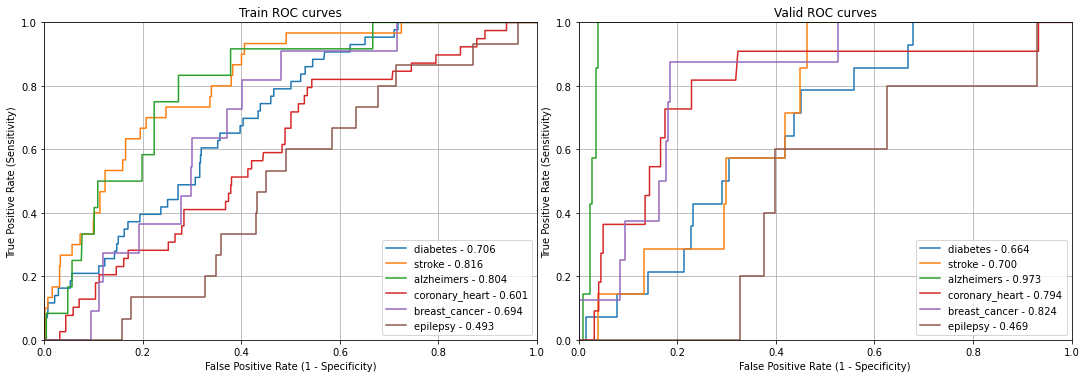

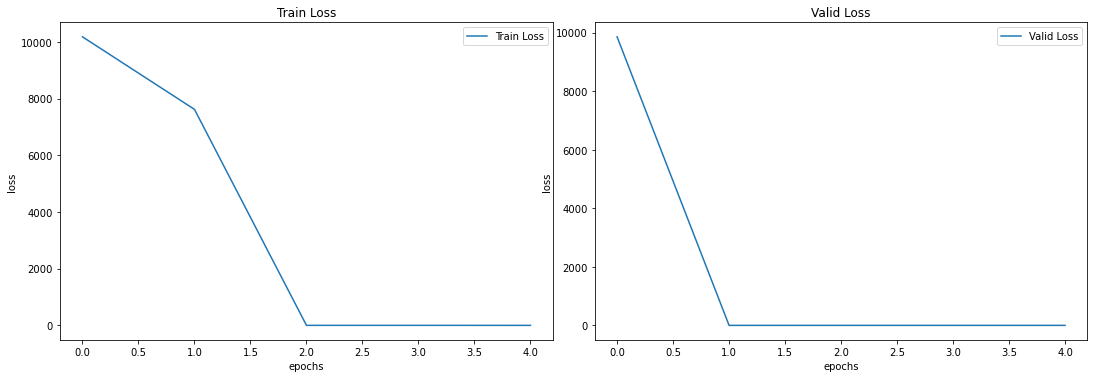

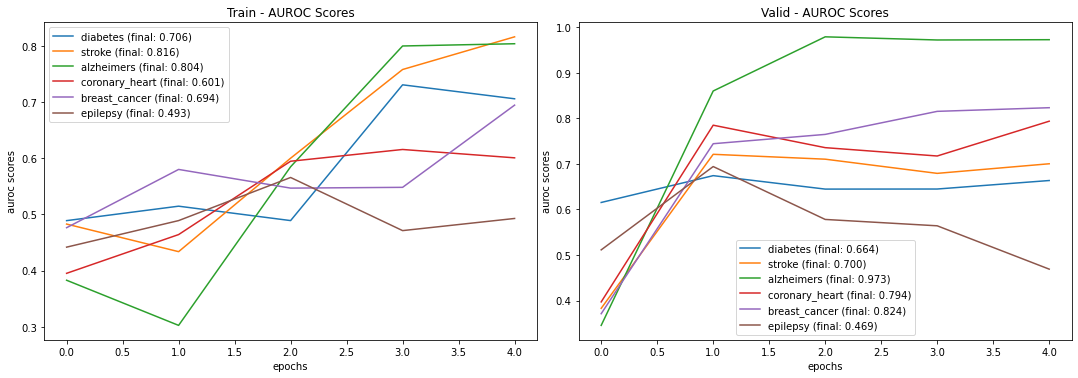

In [ ]:
plot_fit_results(h, labels)


Prediction Summary ...
                auroc_score  optimal_threshold     auroc_95_ci
diabetes           0.755117           0.574707  (0.674, 0.827)
stroke             0.920860           0.958984  (0.845, 0.979)
alzheimers         0.907569           1.465820  (0.858, 0.953)
coronary_heart     0.812094           0.529297  (0.691, 0.918)
breast_cancer      0.934549           1.244141  (0.854, 0.996)
epilepsy           0.334764           0.261475  (0.258, 0.405)


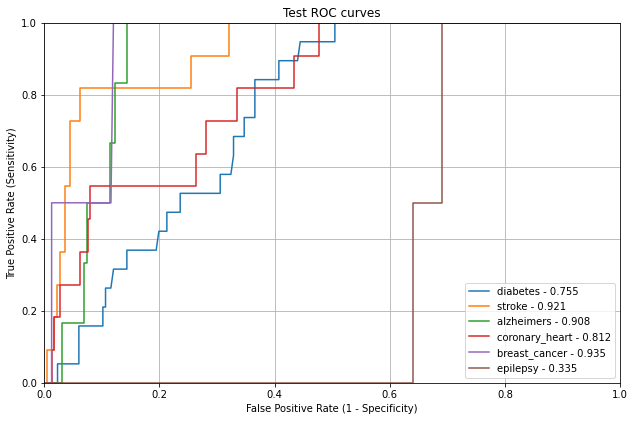

In [ ]:
h = summarize_prediction(h, labels)

In [ ]:
h.prediction_summary

,auroc_score,optimal_threshold,auroc_95_ci
diabetes,0.755117,0.574707,"(0.674, 0.827)"
stroke,0.920860,0.958984,"(0.845, 0.979)"
alzheimers,0.907569,1.465820,"(0.858, 0.953)"
coronary_heart,0.812094,0.529297,"(0.691, 0.918)"
breast_cancer,0.934549,1.244141,"(0.854, 0.996)"
epilepsy,0.334764,0.261475,"(0.258, 0.405)"


## Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_basics.ipynb.
Converted 01_preprocessing_clean.ipynb.
Converted 02_preprocessing_vocab.ipynb.
Converted 03_preprocessing_transform.ipynb.
Converted 04_data.ipynb.
Converted 05_metrics.ipynb.
Converted 06_learn.ipynb.
Converted 07_models.ipynb.
Converted 08_experiment.ipynb.
Converted 999_amp_testing.ipynb.
Converted 999_fusion.ipynb.
Converted 99_quick_walkthru.ipynb.
Converted 99_running_exps.ipynb.
Converted index.ipynb.
